In [1]:
pip install tensorflow opencv-python matplotlib numpy


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [2]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import smtplib
from email.mime.text import MIMEText


In [3]:
import cv2
import os

def video_to_frames(video_folder, output_folder, label):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for video_filename in os.listdir(video_folder):
        video_path = os.path.join(video_folder, video_filename)
        if not os.path.isfile(video_path):
            continue
        
        cap = cv2.VideoCapture(video_path)
        count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame_filename = f"{label}_{os.path.splitext(video_filename)[0]}_{count}.jpg"
            frame_path = os.path.join(output_folder, frame_filename)
            cv2.imwrite(frame_path, frame)
            count += 1
        cap.release()

# Convert video frames for violence videos
video_to_frames(r'C:\Users\poorv\Downloads\archive\Real Life Violence Dataset\Violence', 'dataset/violence', 'violence')

# Convert video frames for non-violence videos
video_to_frames(r'C:\Users\poorv\Downloads\archive\Real Life Violence Dataset\NonViolence', 'dataset/non-violence', 'non-violence')



In [4]:
dataset_path = r'C:\Users\poorv\Downloads\archive\dataset'
batch_size = 32
img_size = (224, 224)

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)


Found 229896 images belonging to 2 classes.
Found 57473 images belonging to 2 classes.


In [5]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [6]:
epochs = 10

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)


Epoch 1/10


C:\Users\poorv\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7184/7184 ━━━━━━━━━━━━━━━━━━━━ 4227s 587ms/step - accuracy: 0.8774 - loss: 0.2845 - val_accuracy: 0.8933 - val_loss: 0.2688
Epoch 2/10
7184/7184 ━━━━━━━━━━━━━━━━━━━━ 0s 28us/step - accuracy: 0.8125 - loss: 0.5366 - val_accuracy: 1.0000 - val_loss: 0.0045
Epoch 3/10


C:\ProgramData\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


7184/7184 ━━━━━━━━━━━━━━━━━━━━ 1764s 245ms/step - accuracy: 0.9008 - loss: 0.2420 - val_accuracy: 0.9196 - val_loss: 0.2173
Epoch 4/10
7184/7184 ━━━━━━━━━━━━━━━━━━━━ 0s 13us/step - accuracy: 0.7812 - loss: 0.6544 - val_accuracy: 1.0000 - val_loss: 0.0190
Epoch 5/10
7184/7184 ━━━━━━━━━━━━━━━━━━━━ 1748s 243ms/step - accuracy: 0.9012 - loss: 0.2399 - val_accuracy: 0.8955 - val_loss: 0.2696
Epoch 6/10
7184/7184 ━━━━━━━━━━━━━━━━━━━━ 0s 13us/step - accuracy: 0.9375 - loss: 0.1952 - val_accuracy: 0.0000e+00 - val_loss: 1.3299
Epoch 7/10
7184/7184 ━━━━━━━━━━━━━━━━━━━━ 1763s 245ms/step - accuracy: 0.9005 - loss: 0.2415 - val_accuracy: 0.8986 - val_loss: 0.2594
Epoch 8/10
7184/7184 ━━━━━━━━━━━━━━━━━━━━ 0s 12us/step - accuracy: 0.9062 - loss: 0.2598 - val_accuracy: 1.0000 - val_loss: 0.2791
Epoch 9/10
7184/7184 ━━━━━━━━━━━━━━━━━━━━ 1775s 247ms/step - accuracy: 0.9016 - loss: 0.2390 - val_accuracy: 0.9301 - val_loss: 0.1932
Epoch 10/10
7184/7184 ━━━━━━━━━━━━━━━━━━━━ 0s 10us/step - accuracy: 0.8750

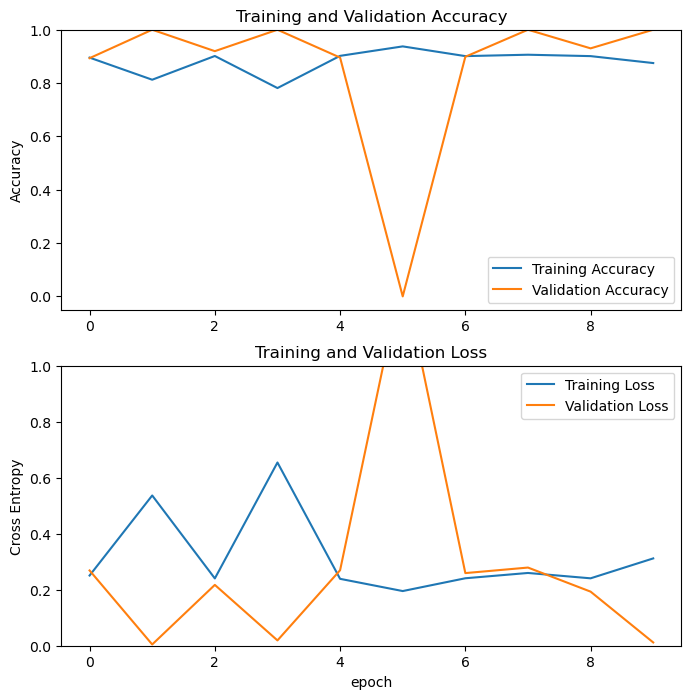

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [14]:
import tensorflow as tf

# Save the model to the path using double backslashes
model.save('C:\\Users\\poorv\\Downloads\\archive\\trainingmodel.h5')
